In [5]:
from mofapy2.run.entry_point import entry_point
import pandas as pd
import numpy as np
import os
import scanpy as sc
import mofax as mfx

from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc
import plotnine as pn

# initialise the entry point
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [6]:
current_path = globals()["_dh"][0]
out_file = current_path / ".." / ".." / "data" / "prc" / "vis" / "mofa_test.hdf5" / "cellranger"
visium_path = current_path / ".." / ".." / "data" / "prc" / "vis" / "processed"
visium_samples = [f.split(".")[0] for f in os.listdir(visium_path) if not f.startswith(".")]
print(np.array(visium_samples))

['MS549H' 'CO85' 'MS371' 'MS197U' 'cellranger' 'CO41' 'MS377T' 'MS229'
 'CO37' 'MS497I' 'CO40' 'CO96' 'MS371N' 'cellbender' 'MS586' 'MS197D'
 'MS94' 'CO74' 'MS377N' 'MS549T' 'MS411' 'MS466' 'MS377I' 'MS497T']


In [7]:
sample_meta = pd.read_excel(current_path / ".." / ".." / "data" / "Metadata_all.xlsx", sheet_name="Visium")

In [8]:
df_list = []
for model in ["all", "condition"]:
    for ct_metric in ["abunds", "props_ilr"]:
        for image_features in ["None", "histogram", "summary", "texture"]:
            for n_factors in [5, 10]:
                out_dir = current_path / ".." / ".." / "data" / "prc" / "vis" / "mofa_tests" / "cellranger" / f"{model}__{ct_metric}__{image_features}__{str(n_factors)}"
                out_file = out_dir / "mofa_model.hdf5"
                if out_file.exists():
                    print(f"Processing {out_file}")
                    m = mfx.mofa_model(out_file)
                    df = m.get_r2()
                    df = df[~df.View.isin(["histogram", "summary", "texture"])] # remove all image_feature views: ["histogram", "summary", "texture"]
                    # geometric mean over views, sum over factors, mean over groups
                    stat1 = df.drop("View", axis=1).groupby(["Group", "Factor"]).apply(lambda x: np.prod(x)**(1/len(x))).groupby("Group").sum().R2.mean()
                    stat2 = df.drop("View", axis=1).groupby(["Group", "Factor"]).apply(lambda x: np.prod(x)**(1/len(x))).groupby("Group").sum().R2.median()
                    df_out = pd.DataFrame({"model": model, "ct_metric": ct_metric, "image_features": image_features, "set_factors": n_factors, "stat1": stat1, "stat2": stat2}, 
                                          index=[0])
                    df_out["actual_factors"] = m.get_factors().shape[1]
                    df_list.append(df_out)
                else:
                    print(f"File {out_file} does not exist")
df = pd.concat(df_list)

Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellranger/all__abunds__None__5/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellranger/all__abunds__None__10/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellranger/all__abunds__histogram__5/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellranger/all__abunds__histogram__10/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellranger/all__abunds__summary__5/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellranger/all__abunds__summary__10/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellranger/all__abunds__texture__5/mofa_mo

In [9]:
df.sort_values("stat1", ascending=False)

,model,ct_metric,image_features,set_factors,stat1,stat2,actual_factors
0,all,abunds,None,10,42.543395,43.089174,7
0,condition,abunds,None,10,40.790241,42.444380,7
0,all,props_ilr,None,10,39.474224,36.387187,8
0,all,abunds,summary,10,38.174827,34.399149,8
0,condition,abunds,histogram,10,37.688627,38.010399,9
0,all,props_ilr,summary,10,37.282680,34.526308,9
0,all,props_ilr,histogram,10,36.944729,35.241304,8
0,all,abunds,summary,5,35.542744,22.547679,4
0,all,abunds,histogram,10,35.094527,39.672689,8
0,all,abunds,None,5,33.848349,35.237786,4


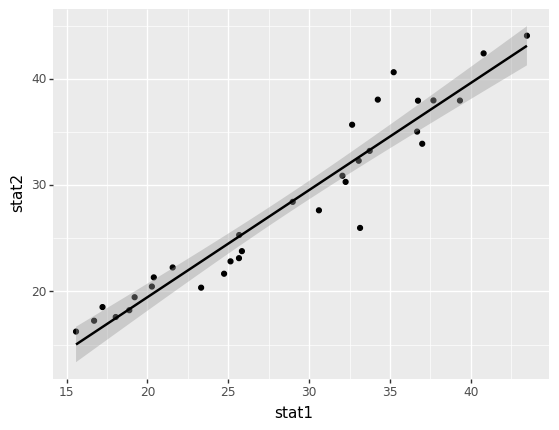

In [ ]:
# scatter plot of stat1 vs stat2
g = pn.ggplot(df, pn.aes(x="stat1", y="stat2")) + pn.geom_point() + pn.geom_smooth(method="lm")
print(g)

In [11]:
current_path = globals()["_dh"][0]
out_file = current_path / ".." / ".." / "data" / "prc" / "vis" / "mofa_test.hdf5" / "cellbender"
visium_path = current_path / ".." / ".." / "data" / "prc" / "vis" / "processed"
visium_samples = [f.split(".")[0] for f in os.listdir(visium_path) if not f.startswith(".")]
print(np.array(visium_samples))

['MS549H' 'CO85' 'MS371' 'MS197U' 'cellranger' 'CO41' 'MS377T' 'MS229'
 'CO37' 'MS497I' 'CO40' 'CO96' 'MS371N' 'cellbender' 'MS586' 'MS197D'
 'MS94' 'CO74' 'MS377N' 'MS549T' 'MS411' 'MS466' 'MS377I' 'MS497T']


In [12]:
sample_meta = pd.read_excel(current_path / ".." / ".." / "data" / "Metadata_all.xlsx", sheet_name="Visium")

In [15]:
df_list = []
for model in ["all", "condition"]:
    for ct_metric in ["abunds", "props_ilr"]:
        for image_features in ["None", "histogram", "summary", "texture"]:
            for n_factors in [5, 10]:
                out_dir = current_path / ".." / ".." / "data" / "prc" / "vis" / "mofa_tests" / "cellbender" / f"{model}__{ct_metric}__{image_features}__{str(n_factors)}"
                out_file = out_dir / "mofa_model.hdf5"
                if out_file.exists():
                    print(f"Processing {out_file}")
                    m = mfx.mofa_model(out_file)
                    df = m.get_r2()
                    df = df[~df.View.isin(["histogram", "summary", "texture"])] # remove all image_feature views: ["histogram", "summary", "texture"]
                    # geometric mean over views, sum over factors, mean over groups
                    stat1 = df.drop("View", axis=1).groupby(["Group", "Factor"]).apply(lambda x: np.prod(x)**(1/len(x))).groupby("Group").sum().R2.mean()
                    stat2 = df.drop("View", axis=1).groupby(["Group", "Factor"]).apply(lambda x: np.prod(x)**(1/len(x))).groupby("Group").sum().R2.median()
                    df_out = pd.DataFrame({"model": model, "ct_metric": ct_metric, "image_features": image_features, "set_factors": n_factors, "stat1": stat1, "stat2": stat2}, 
                                          index=[0])
                    df_out["actual_factors"] = m.get_factors().shape[1]
                    df_list.append(df_out)
                else:
                    print(f"File {out_file} does not exist")
df = pd.concat(df_list)

Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellbender/all__abunds__None__5/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellbender/all__abunds__None__10/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellbender/all__abunds__histogram__5/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellbender/all__abunds__histogram__10/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellbender/all__abunds__summary__5/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellbender/all__abunds__summary__10/mofa_model.hdf5
Processing /Users/pschafer/Projects/VisiumMS/scripts/notebooks/../../data/prc/vis/mofa_tests/cellbender/all__abunds__texture__5/mofa_mo

In [16]:
df.sort_values("stat1", ascending=False)

,model,ct_metric,image_features,set_factors,stat1,stat2,actual_factors
0,condition,abunds,None,10,44.773670,46.698581,7
0,all,abunds,None,10,44.743631,49.801466,7
0,all,abunds,histogram,10,39.360460,44.808427,9
0,condition,abunds,histogram,10,37.658360,41.496984,9
0,all,abunds,summary,10,37.156022,33.744141,8
0,all,abunds,None,5,37.146566,43.331486,4
0,condition,abunds,None,5,37.066543,40.625168,4
0,condition,abunds,summary,10,36.845571,31.174709,8
0,all,props_ilr,histogram,10,34.380994,33.100176,9
0,condition,props_ilr,None,10,34.349229,34.271526,9


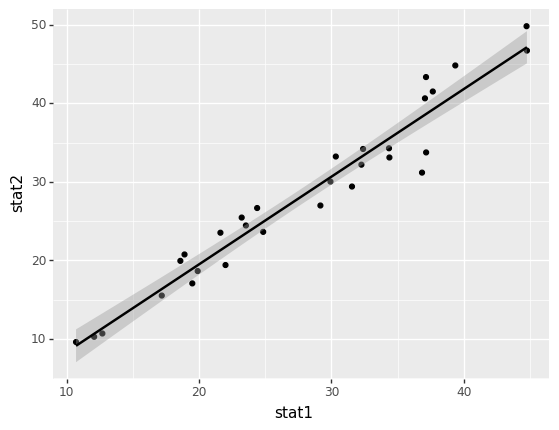

In [17]:
# scatter plot of stat1 vs stat2
g = pn.ggplot(df, pn.aes(x="stat1", y="stat2")) + pn.geom_point() + pn.geom_smooth(method="lm")
print(g)